# System Analysis

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import plotly as px
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy import stats
import sranodec as anom

First we have to read data from our 3 pickle files.

In [2]:
cpu = pd.read_pickle('../../data/cpu.pkl')
mem = pd.read_pickle('../../data/memory.pkl')
net = pd.read_pickle('../../data/network.pkl')

# Now we change the dataframes to polars for faster processing
cpu = pl.from_pandas(cpu)
mem = pl.from_pandas(mem)
net = pl.from_pandas(net)

Now we have to change the `timestamp` column to datetime to utilize the python functionalities.

In [3]:
cpu = cpu.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))
net = net.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))
mem = mem.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))

In [4]:
cpu.__str__

<bound method DataFrame.__str__ of shape: (1_331_490, 8)
┌───────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬──────────┐
│ cpu.cores ┆ cpu.idle.p ┆ cpu.user.p ┆ cpu.system ┆ cpu.steal. ┆ timestamp ┆ event     ┆ node     │
│ ---       ┆ ct         ┆ ct         ┆ .pct       ┆ pct        ┆ ---       ┆ ---       ┆ ---      │
│ i64       ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ datetime[ ┆ str       ┆ str      │
│           ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ μs]       ┆           ┆          │
╞═══════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪══════════╡
│ 4         ┆ 3.8109     ┆ 0.0813     ┆ 0.1078     ┆ null       ┆ 2023-03-1 ┆ system.cp ┆ QASERVER │
│           ┆            ┆            ┆            ┆            ┆ 3 07:04:3 ┆ u         ┆          │
│           ┆            ┆            ┆            ┆            ┆ 1.079     ┆           ┆          │
│ 4         ┆ 3.7359     ┆ 0.1422 

# CPU

## Calculate standarized values

Now we want to calculate the standard values by dividing the percentage of cpu usage by the number of cores.

In [4]:
cpu2 = (
    cpu
    .lazy()
    .with_columns(
        (pl.col('cpu.idle.pct') / pl.col('cpu.cores')).alias('idle.pct'),
        (pl.col('cpu.system.pct') / pl.col('cpu.cores')).alias('system.pct'),
        (pl.col('cpu.user.pct') / pl.col('cpu.cores')).alias('user.pct'),
        (pl.col('cpu.steal.pct') / pl.col('cpu.cores')).alias('steal.pct'),
    )
    .collect()
)

The code below is a resampling implementation in polars, this will not be used for now as matplotlib is easier to use with pandas

In [28]:
# out1 = cpu2.upsample(time_column="timestamp", every="1m").fill_null(strategy="forward")

argument in operation 'upsample' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


We drop the original columns, as the standarized values help us more now.

In [5]:
out1 = cpu2.drop(columns=['cpu.idle.pct','cpu.user.pct','cpu.system.pct','cpu.steal.pct'])
# out1 = out1.drop(columns=['cpu.idle.pct','cpu.user.pct','cpu.system.pct','cpu.steal.pct'])

In [35]:
out1

shape: (26_681, 8)
┌───────────────┬───────────┬────────────┬──────────┬──────────┬────────────┬──────────┬───────────┐
│ timestamp     ┆ cpu.cores ┆ event      ┆ node     ┆ idle.pct ┆ system.pct ┆ user.pct ┆ steal.pct │
│ ---           ┆ ---       ┆ ---        ┆ ---      ┆ ---      ┆ ---        ┆ ---      ┆ ---       │
│ datetime[μs]  ┆ i64       ┆ str        ┆ str      ┆ f64      ┆ f64        ┆ f64      ┆ f64       │
╞═══════════════╪═══════════╪════════════╪══════════╪══════════╪════════════╪══════════╪═══════════╡
│ 2023-03-13    ┆ 4         ┆ system.cpu ┆ QASERVER ┆ 0.952725 ┆ 0.02695    ┆ 0.020325 ┆ null      │
│ 07:04:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-13    ┆ 4         ┆ system.cpu ┆ QASERVER ┆ 0.952725 ┆ 0.02695    ┆ 0.020325 ┆ null      │
│ 07:05:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-13    ┆ 4         ┆ system.cpu ┆ QASERVER ┆ 0.952725 ┆ 0.02695    ┆ 0.020325 ┆ null      │
│ 07:06:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-13    ┆ 4         ┆ system.cpu ┆ QASERVER ┆ 0.952725 ┆ 0.02695    ┆ 0.020325 ┆ null      │
│ 07:07:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ …             ┆ …         ┆ …          ┆ …        ┆ …        ┆ …          ┆ …        ┆ …         │
│ 2023-03-31    ┆ 4         ┆ system.cpu ┆ DEVELOP  ┆ 0.9371   ┆ 0.038675   ┆ 0.024225 ┆ null      │
│ 19:41:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-31    ┆ 4         ┆ system.cpu ┆ DEVELOP  ┆ 0.9371   ┆ 0.038675   ┆ 0.024225 ┆ null      │
│ 19:42:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-31    ┆ 4         ┆ system.cpu ┆ DEVELOP  ┆ 0.9371   ┆ 0.038675   ┆ 0.024225 ┆ null      │
│ 19:43:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
│ 2023-03-31    ┆ 4         ┆ system.cpu ┆ DEVELOP  ┆ 0.9371   ┆ 0.038675   ┆ 0.024225 ┆ null      │
│ 19:44:31.079  ┆           ┆            ┆          ┆          ┆            ┆          ┆           │
└───────────────┴───────────┴────────────┴──────────┴──────────┴────────────┴──────────┴───────────┘

## Initial Plotting

First we change from polars dataframes to pandas dataframes as stated previously for a better implementations.

In [6]:
out1 = out1.to_pandas()

Now we resample to have our data every one minute and fill the null values with `first`. Which utilized the previous values.

In [7]:
df_ = out1.resample('1min', on="timestamp").agg("first").ffill()

In [8]:
df_

cpu.cores       event      node  idle.pct  system.pct  \
timestamp                                                                    
2023-03-01 00:00:00        4.0  system.cpu  QASERVER  0.984775    0.010150   
2023-03-01 00:01:00        4.0  system.cpu  QASERVER  0.979275    0.011350   
2023-03-01 00:02:00        4.0  system.cpu  QASERVER  0.965250    0.016800   
2023-03-01 00:03:00        4.0  system.cpu  QASERVER  0.983600    0.009375   
2023-03-01 00:04:00        4.0  system.cpu  QASERVER  0.955475    0.024600   
...                        ...         ...       ...       ...         ...   
2023-03-31 23:56:00       16.0  system.cpu   PRUEBAS  0.998062    0.001125   
2023-03-31 23:57:00       16.0  system.cpu   PRUEBAS  0.997437    0.001250   
2023-03-31 23:58:00       16.0  system.cpu   PRUEBAS  0.997812    0.001125   
2023-03-31 23:59:00       16.0  system.cpu   PRUEBAS  0.997687    0.001063   
2023-04-01 00:00:00       16.0  system.cpu   PRUEBAS  0.991431    0.001500   

                     user.pct  steal.pct  
timestamp                                 
2023-03-01 00:00:00  0.005075        0.0  
2023-03-01 00:01:00  0.009375        0.0  
2023-03-01 00:02:00  0.017950        0.0  
2023-03-01 00:03:00  0.007025        0.0  
2023-03-01 00:04:00  0.019925        0.0  
...                       ...        ...  
2023-03-31 23:56:00  0.000813        0.0  
2023-03-31 23:57:00  0.001250        0.0  
2023-03-31 23:58:00  0.001000        0.0  
2023-03-31 23:59:00  0.001250        0.0  
2023-04-01 00:00:00  0.007006        0.0  

[44641 rows x 7 columns]

In [9]:
df_['idle.pct'] = df_['idle.pct']*100
df_['system.pct'] = df_['system.pct']*100
df_['user.pct'] = df_['user.pct']*100
df_['steal.pct'] = df_['steal.pct']*100

In [21]:
def plot_server_info(df: pd.DataFrame, servers: list):
    """
    This function plots the cpu usage of the servers in the list servers.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the cpu usage of the servers.
    servers : list
        The list of servers to plot.

    Returns
    -------
    None.

    """

    for server in servers:
        fig, ax = plt.subplots(5,1, figsize=(20, 15))

        sum_all = df_[df_['node'] == server]["user.pct"]+df_[df_['node'] == server]["idle.pct"]+df_[df_['node'] == server]["system.pct"]+df_[df_['node'] == server]["steal.pct"]
        ax[0].plot(df_[df_['node'] == server]["idle.pct"])
        ax[0].set_title(f'{server} idle percentage')
        ax[1].plot(df_[df_['node'] == server]["user.pct"])
        ax[1].set_title(f'{server} user percentage')
        ax[2].plot(df_[df_['node'] == server]["system.pct"])
        ax[3].set_title(f'{server} system percentage')
        ax[3].plot(df_[df_['node'] == server]["steal.pct"])
        ax[3].set_title(f'{server} steal percentage')
        ax[4].plot(sum_all)
        ax[4].set_title(f'{server} total percentage')

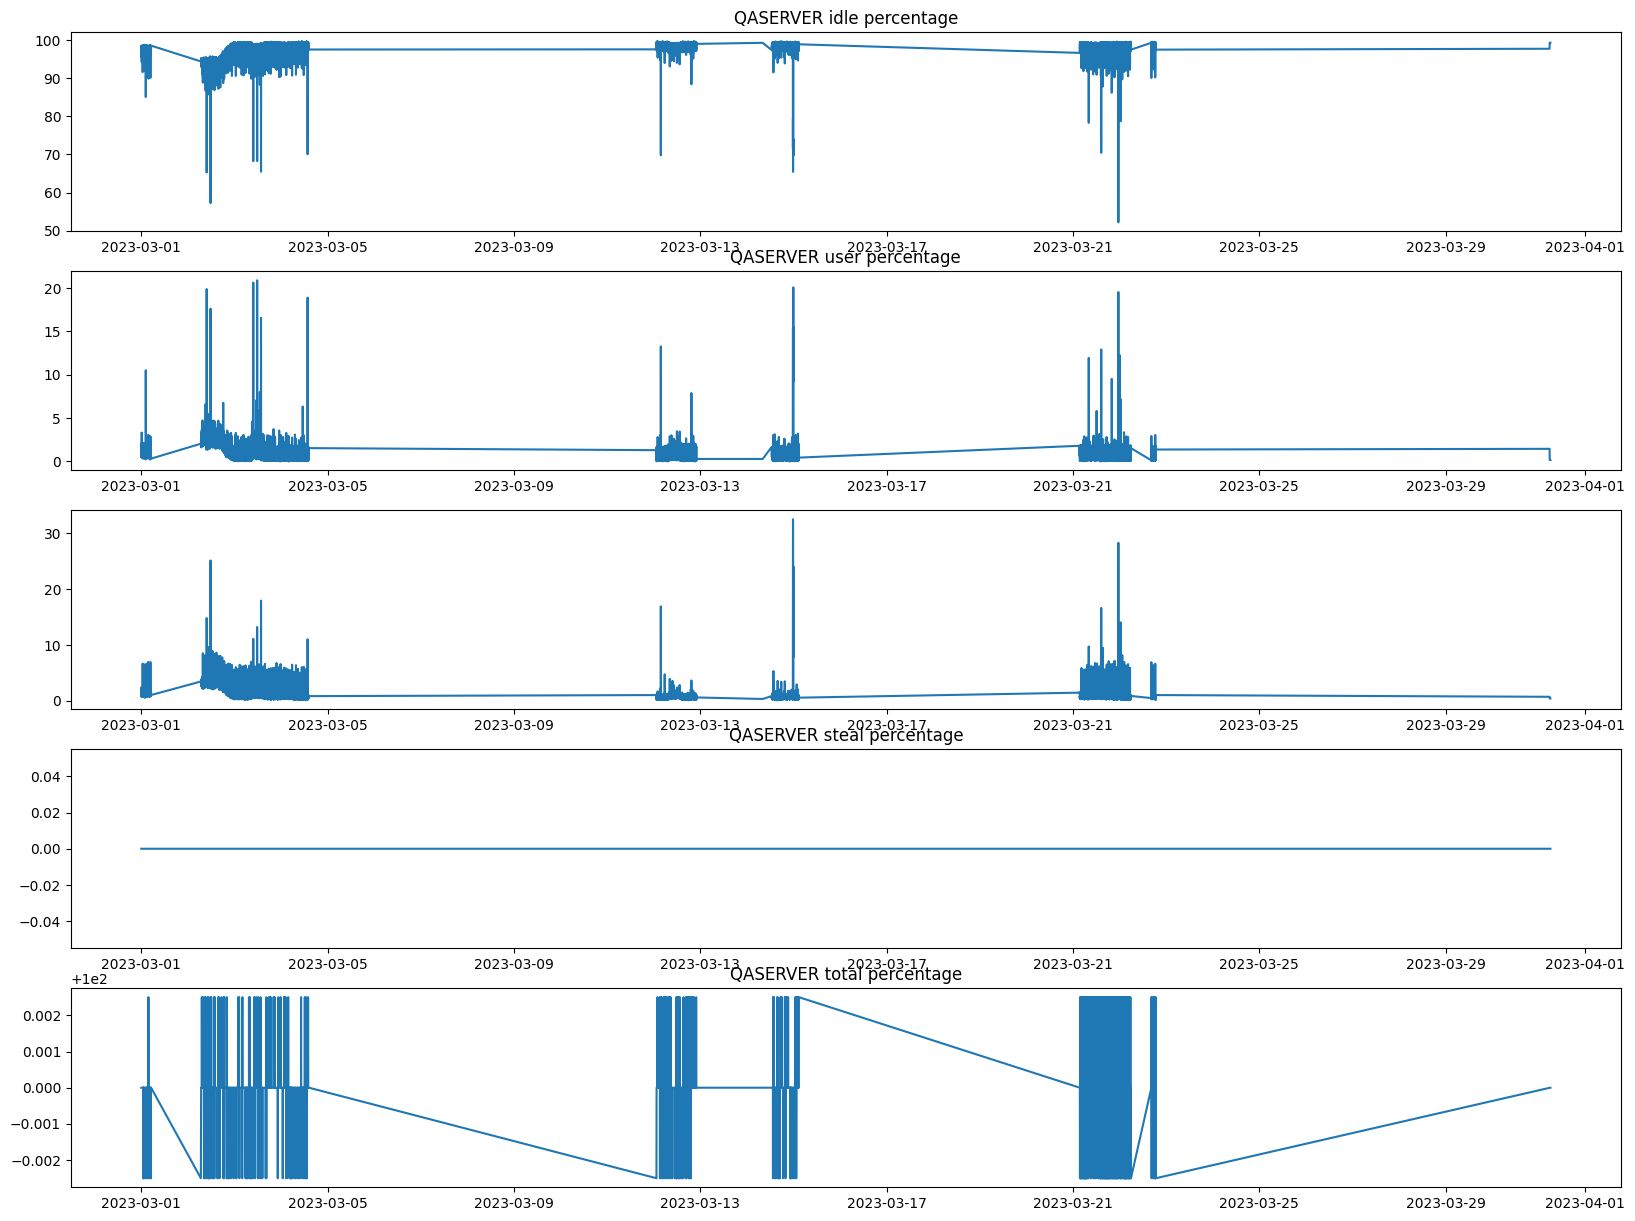

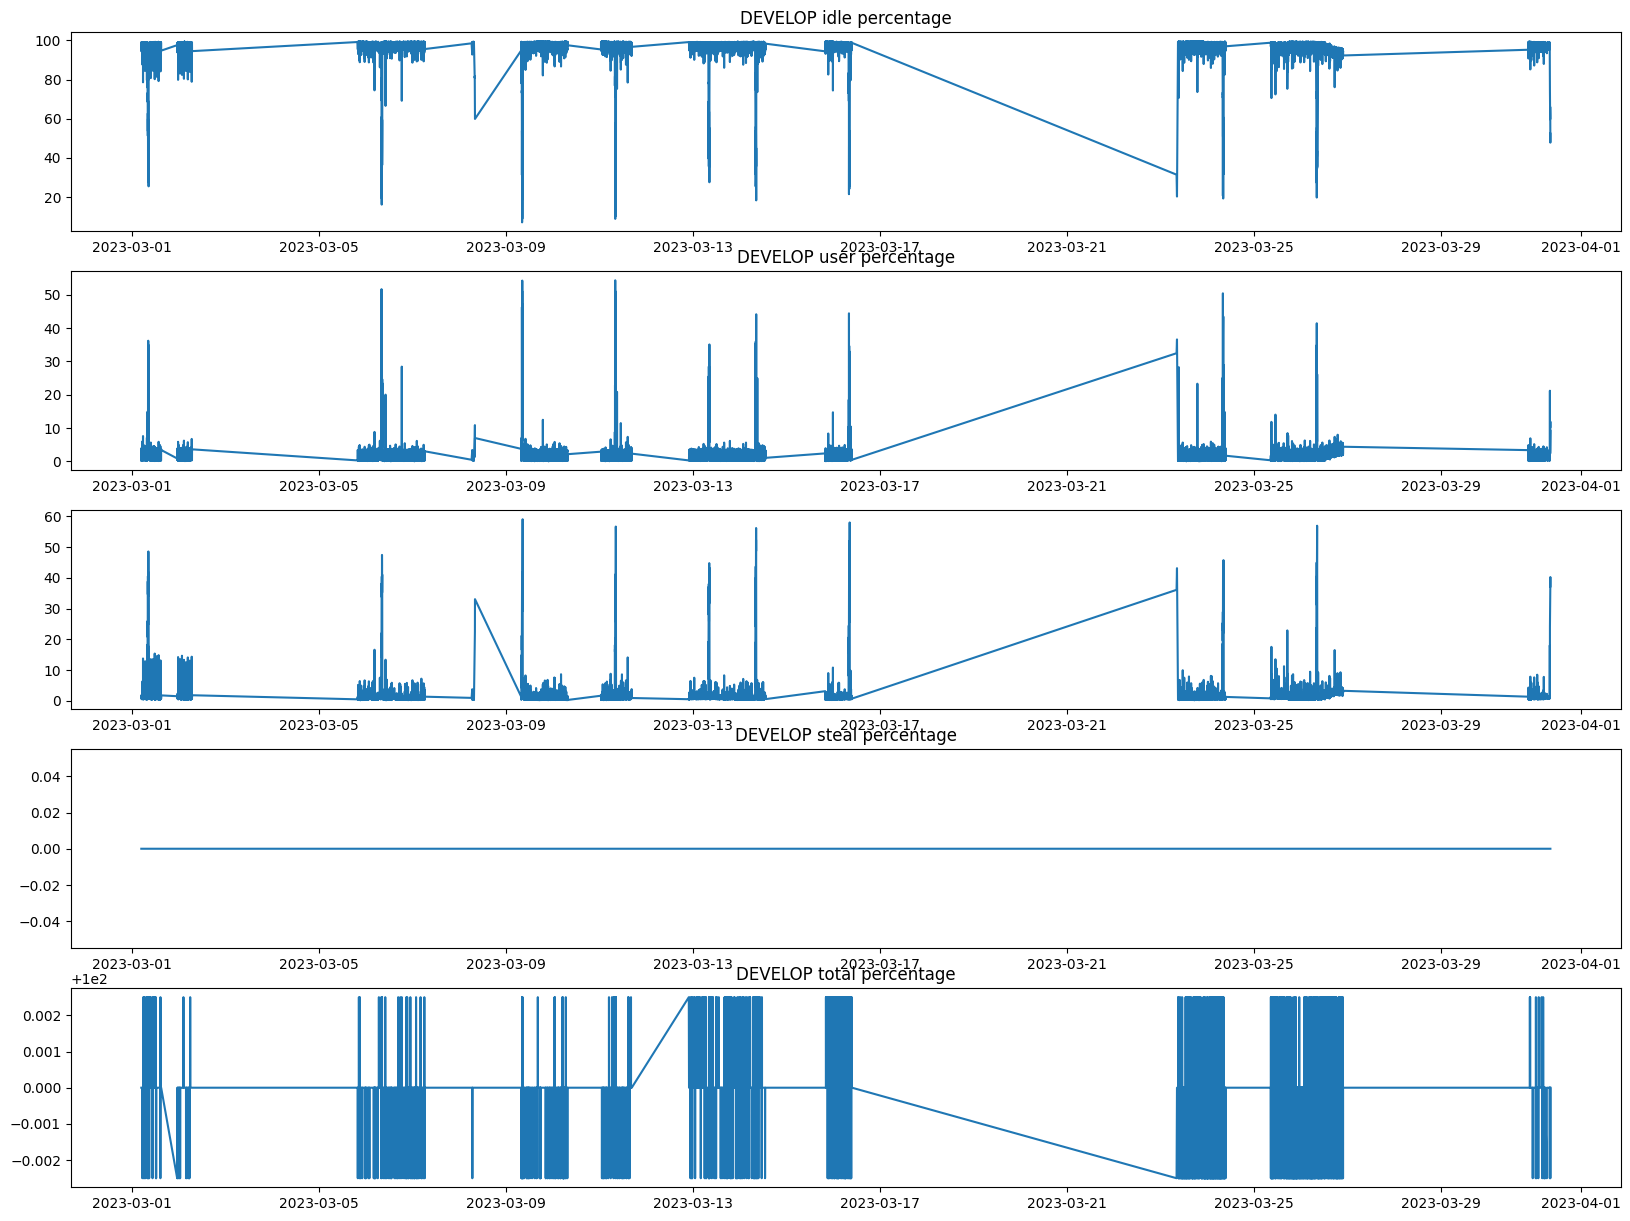

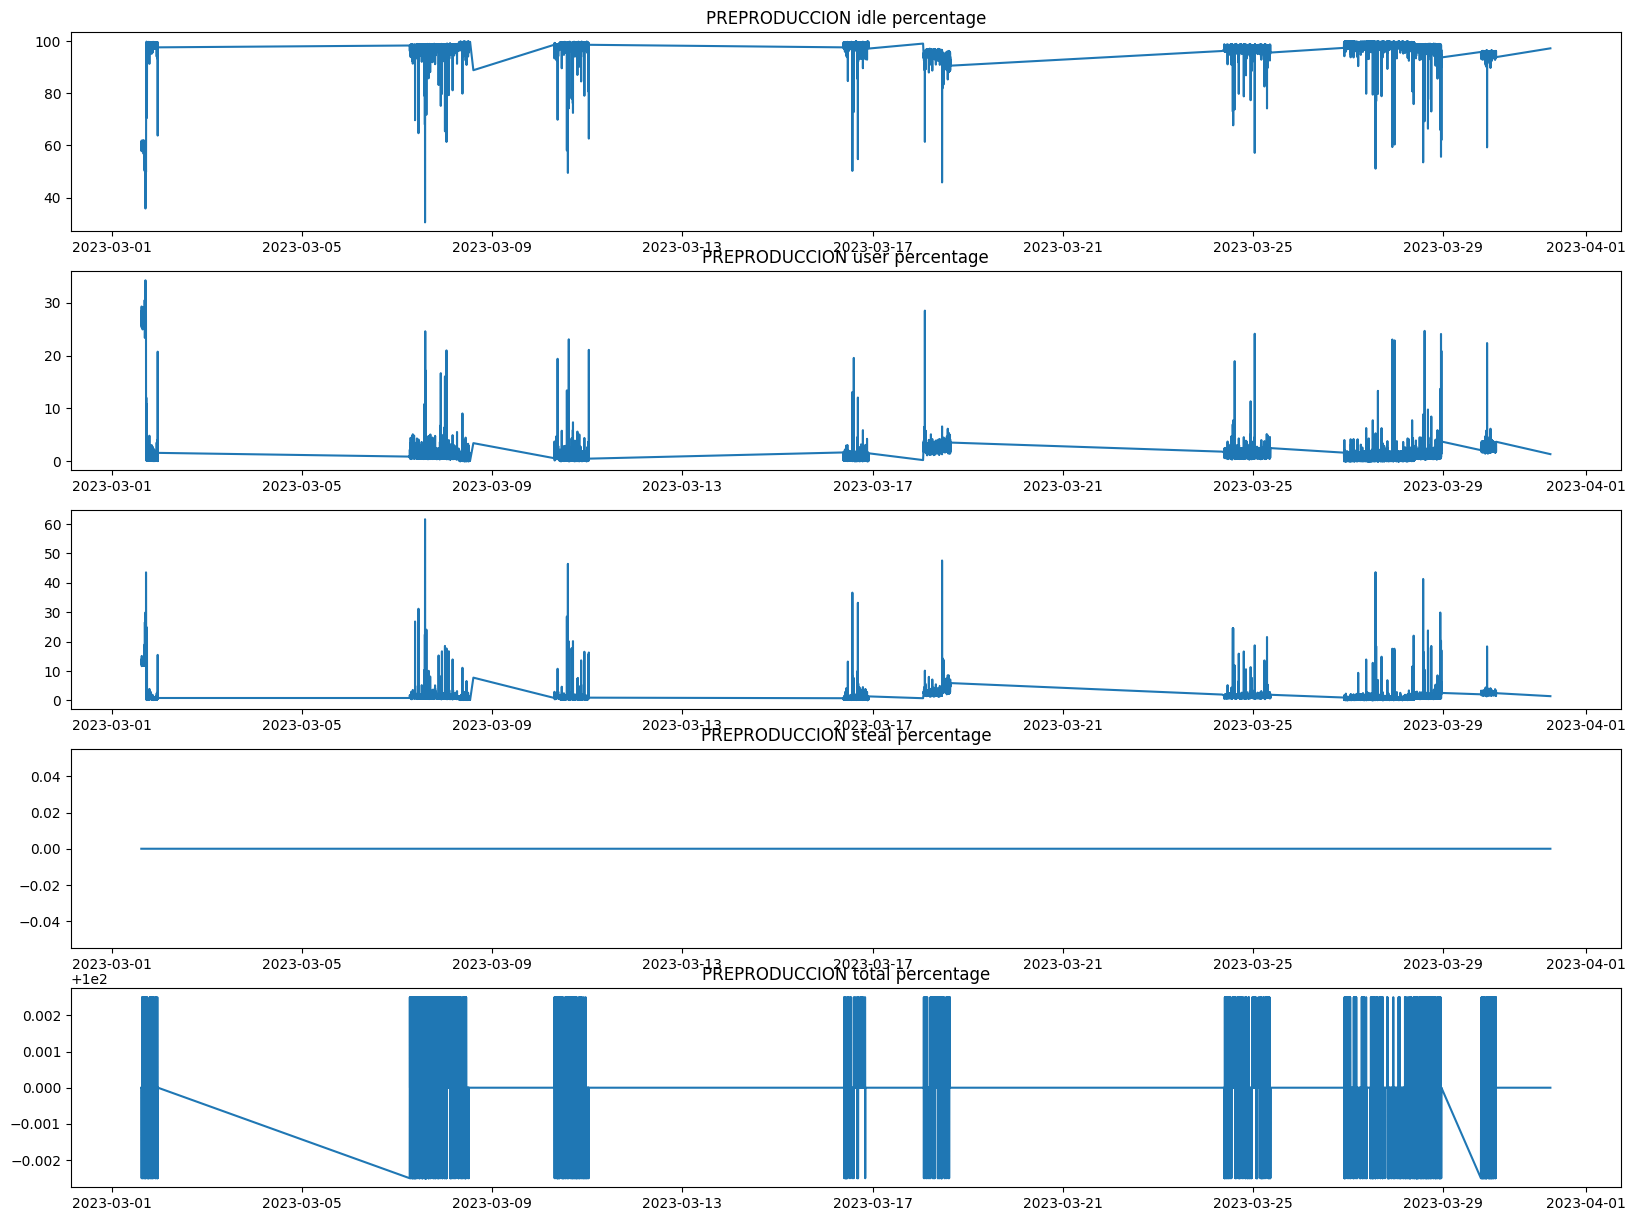

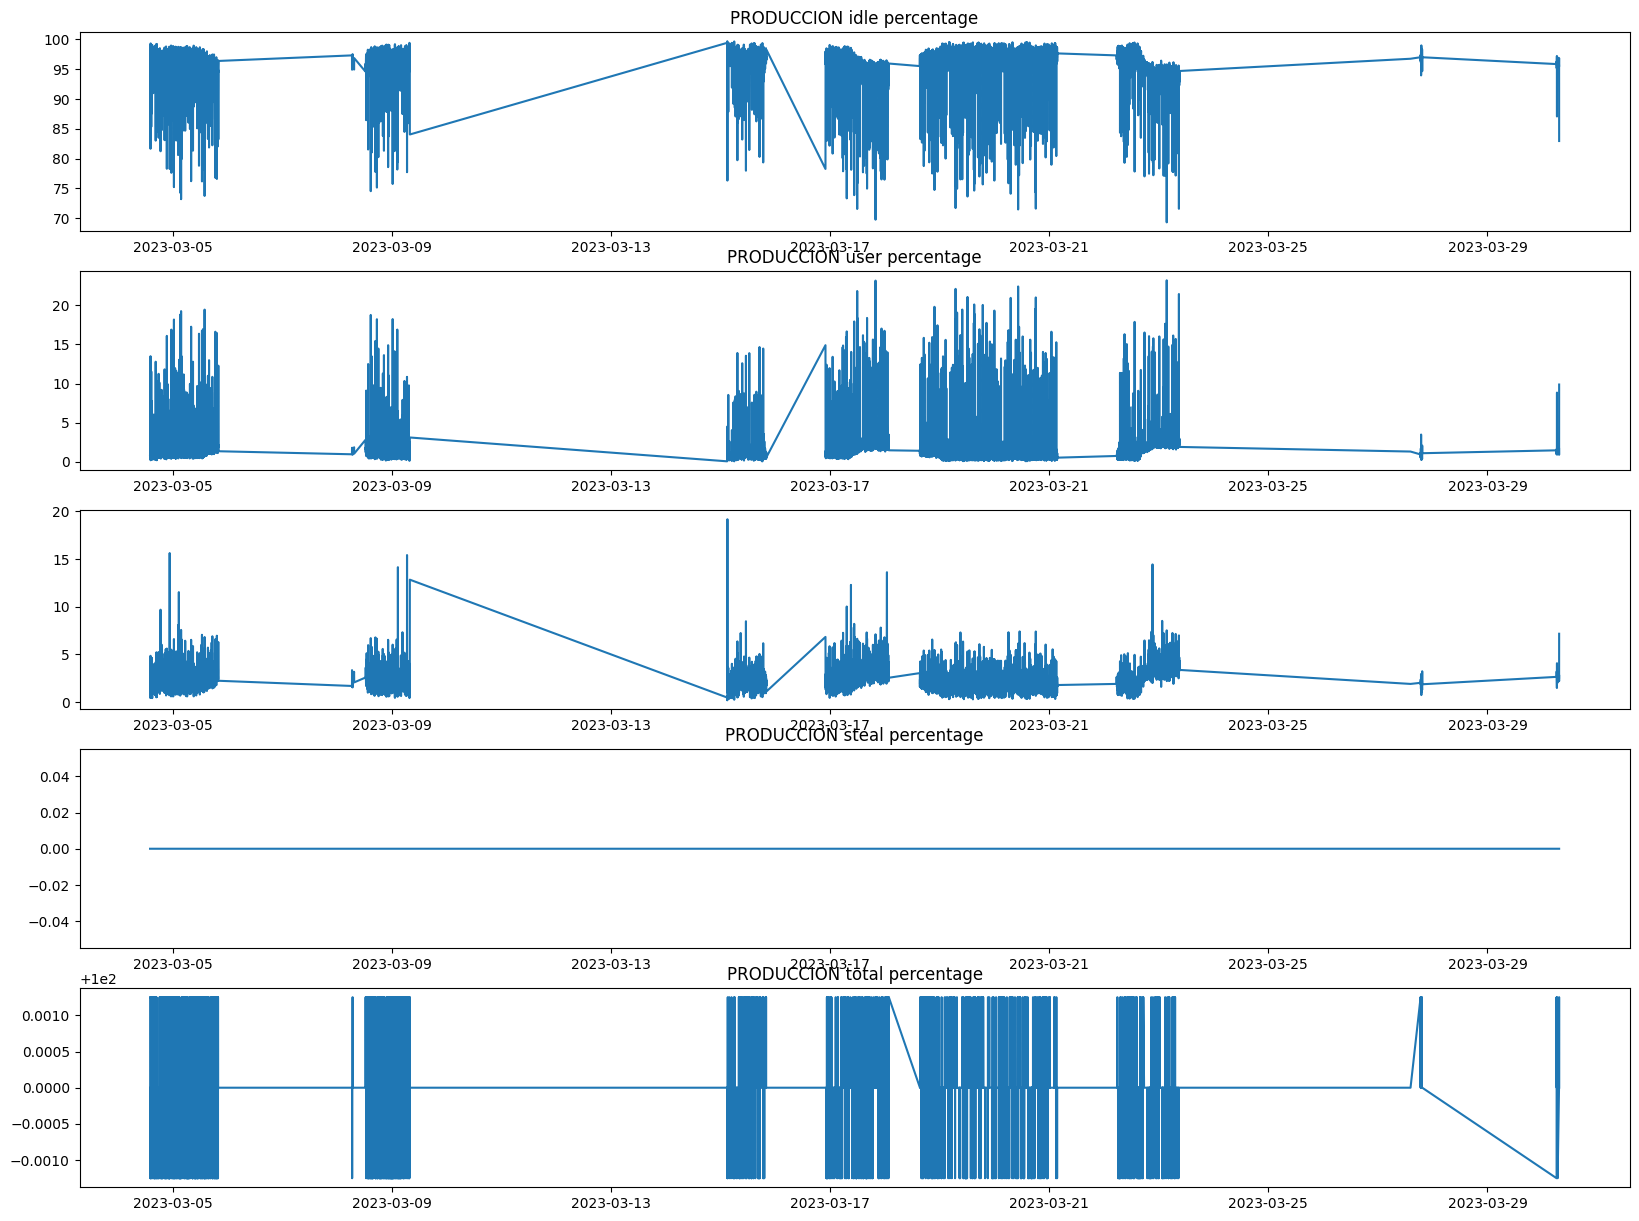

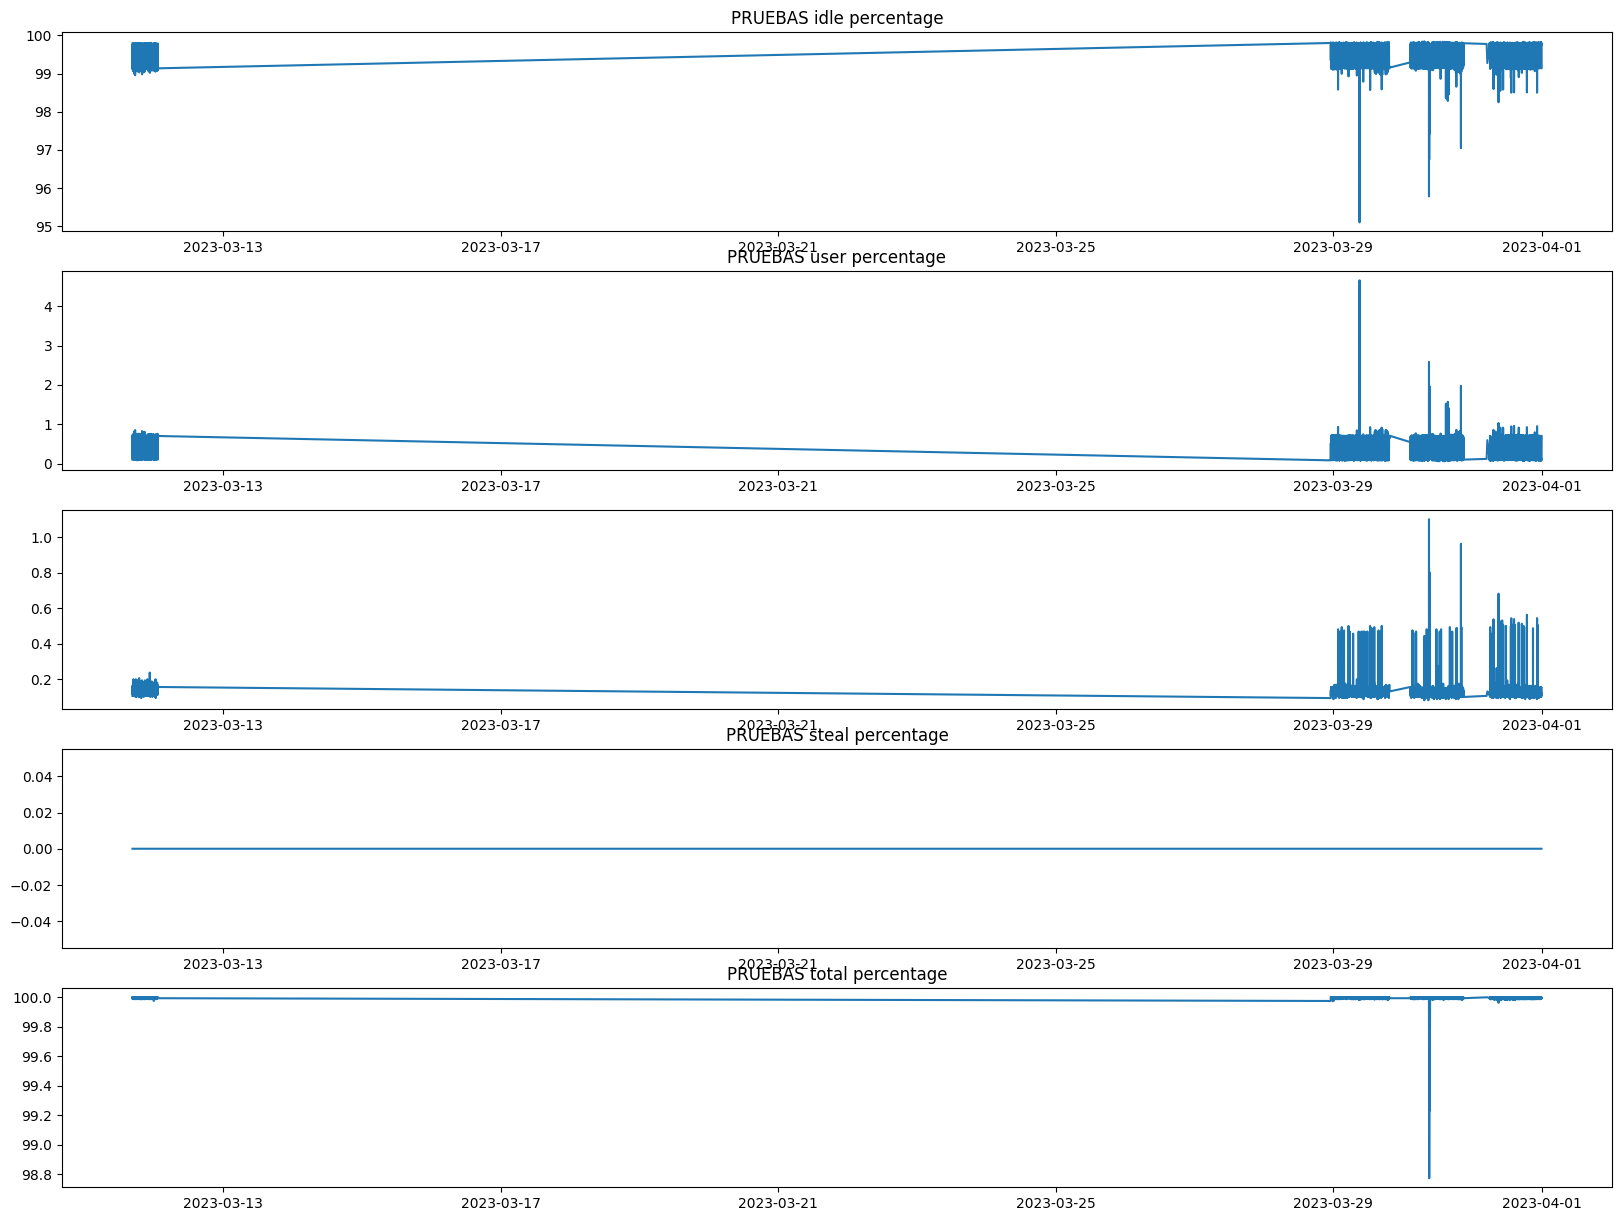

In [22]:
servers = df_['node'].unique()
plot_server_info(df_, servers)

# Network

First we calculate the percentage of use for out network in and out bytes, as having the exact byte value might not be very useful at this moment.

In [4]:
net2 = (
    net
    .lazy()
    .with_columns(
        ((pl.col('network.out.bytes') / (pl.col('network.out.bytes')+pl.col('network.in.bytes'))*100).alias('out.pct')),
        ((pl.col('network.in.bytes') / (pl.col('network.out.bytes')+pl.col('network.in.bytes'))*100).alias('in.pct'))
    )
    .collect()
)

Since we have the percentage we no longer need the bytes, therefore we can get rid of the two columns.

In [5]:
net2 = net2.drop(columns=['network.out.bytes', 'network.in.bytes'])

We convert our dataframe to pandas for an easier time with matplotlib.

In [6]:
out2 = net2.to_pandas()

In [43]:
out2

timestamp           event      node    out.pct  \
0       2023-03-13 07:05:01.081  system.network  QASERVER  57.474349   
1       2023-03-13 07:05:01.081  system.network  QASERVER        NaN   
2       2023-03-13 07:04:41.070  system.network  QASERVER  57.474445   
3       2023-03-13 07:04:41.070  system.network  QASERVER        NaN   
4       2023-03-13 07:14:51.087  system.network  QASERVER  57.474822   
...                         ...             ...       ...        ...   
3993174 2023-03-08 06:24:09.991  system.network   PRUEBAS  50.000000   
3993175 2023-03-08 06:24:29.991  system.network   PRUEBAS        NaN   
3993176 2023-03-08 06:24:29.991  system.network   PRUEBAS  73.160282   
3993177 2023-03-08 06:27:49.991  system.network   PRUEBAS        NaN   
3993178 2023-03-08 06:23:19.991  system.network   PRUEBAS  73.159378   

            in.pct  
0        42.525651  
1              NaN  
2        42.525555  
3              NaN  
4        42.525178  
...            ...  
3993174  50.000000  
3993175        NaN  
3993176  26.839718  
3993177        NaN  
3993178  26.840622  

[3993179 rows x 5 columns]

Now we resample the data to have a 1 min resampling instead of the usual 20 second interval.

In [7]:
out2 = out2.resample('1min', on="timestamp").agg("first").ffill()

In [45]:
out2

event      node    out.pct     in.pct
timestamp                                                          
2023-03-01 00:00:00  system.network  QASERVER  56.682279  43.317721
2023-03-01 00:01:00  system.network  QASERVER  56.682837  43.317163
2023-03-01 00:02:00  system.network  QASERVER  56.682870  43.317130
2023-03-01 00:03:00  system.network  QASERVER  56.682846  43.317154
2023-03-01 00:04:00  system.network  QASERVER  56.682789  43.317211
...                             ...       ...        ...        ...
2023-03-31 23:56:00  system.network   PRUEBAS  72.220960  27.779040
2023-03-31 23:57:00  system.network   PRUEBAS  72.221260  27.778740
2023-03-31 23:58:00  system.network   PRUEBAS  50.000000  50.000000
2023-03-31 23:59:00  system.network   PRUEBAS  72.221937  27.778063
2023-04-01 00:00:00  system.network   PRUEBAS  72.222540  27.777460

[44641 rows x 4 columns]

In [46]:
def plot_network_info(df: pd.DataFrame, servers: list):
    """
    This function plots the cpu usage of the servers in the list servers.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the cpu usage of the servers.
    servers : list
        The list of servers to plot.

    Returns
    -------
    None.

    """

    for server in servers:
        fig, ax = plt.subplots(3,1, figsize=(20, 8))

        sum_all = df[df['node'] == server]["out.pct"]+df[df['node'] == server]["in.pct"]
        ax[0].plot(df[df['node'] == server]["in.pct"])
        ax[0].set_title(f'{server} in percentage')
        ax[1].plot(df[df['node'] == server]["out.pct"])
        ax[1].set_title(f'{server} out percentage')
        ax[2].plot(sum_all)
        ax[2].set_title(f'{server} total percentage')

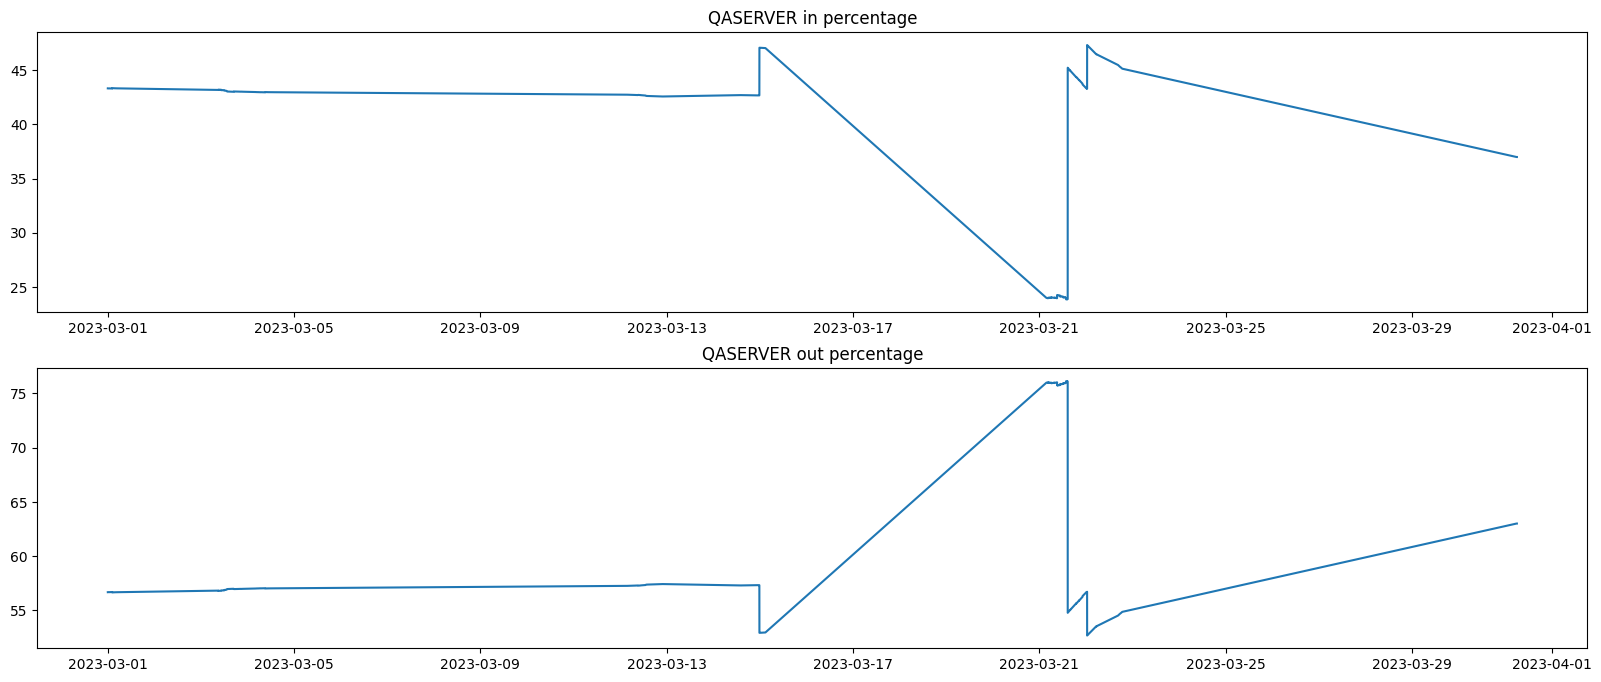

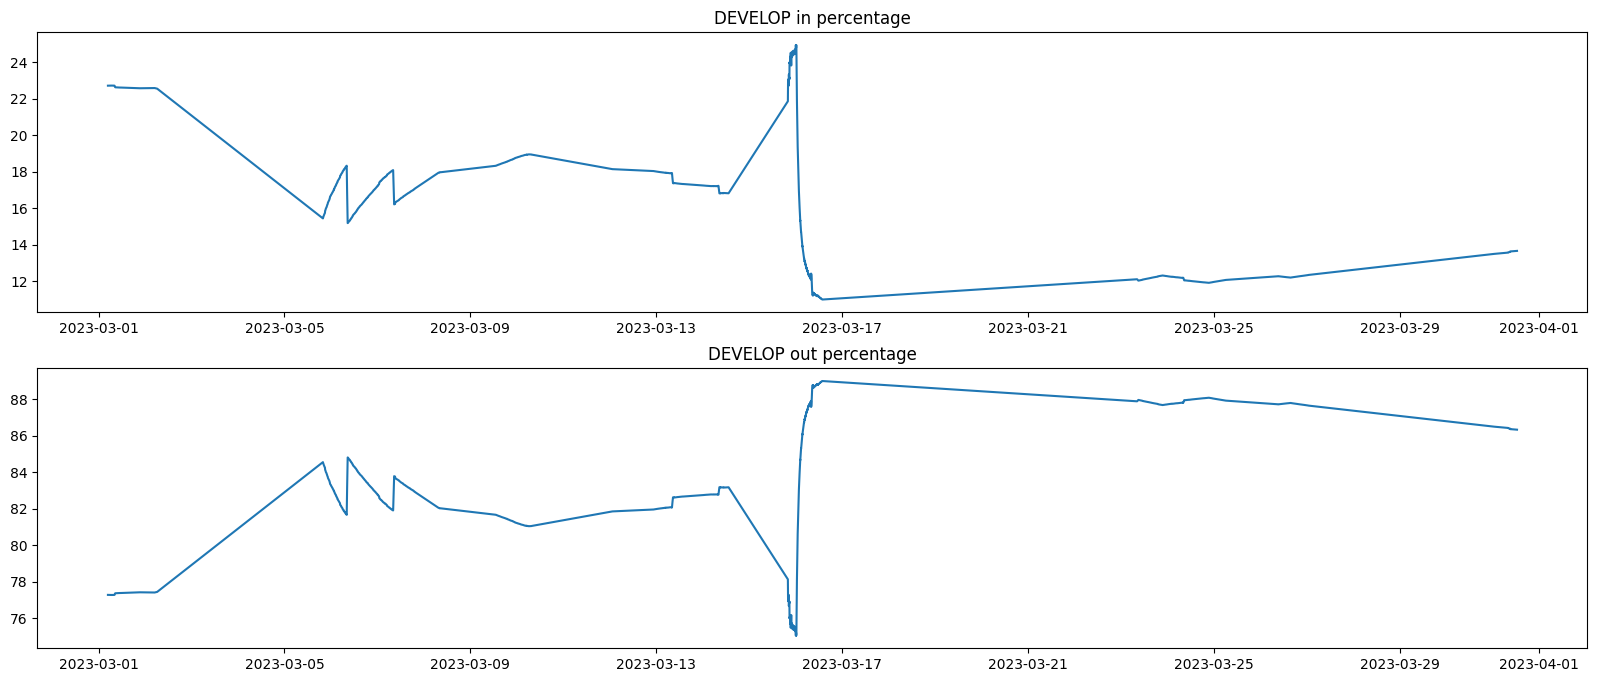

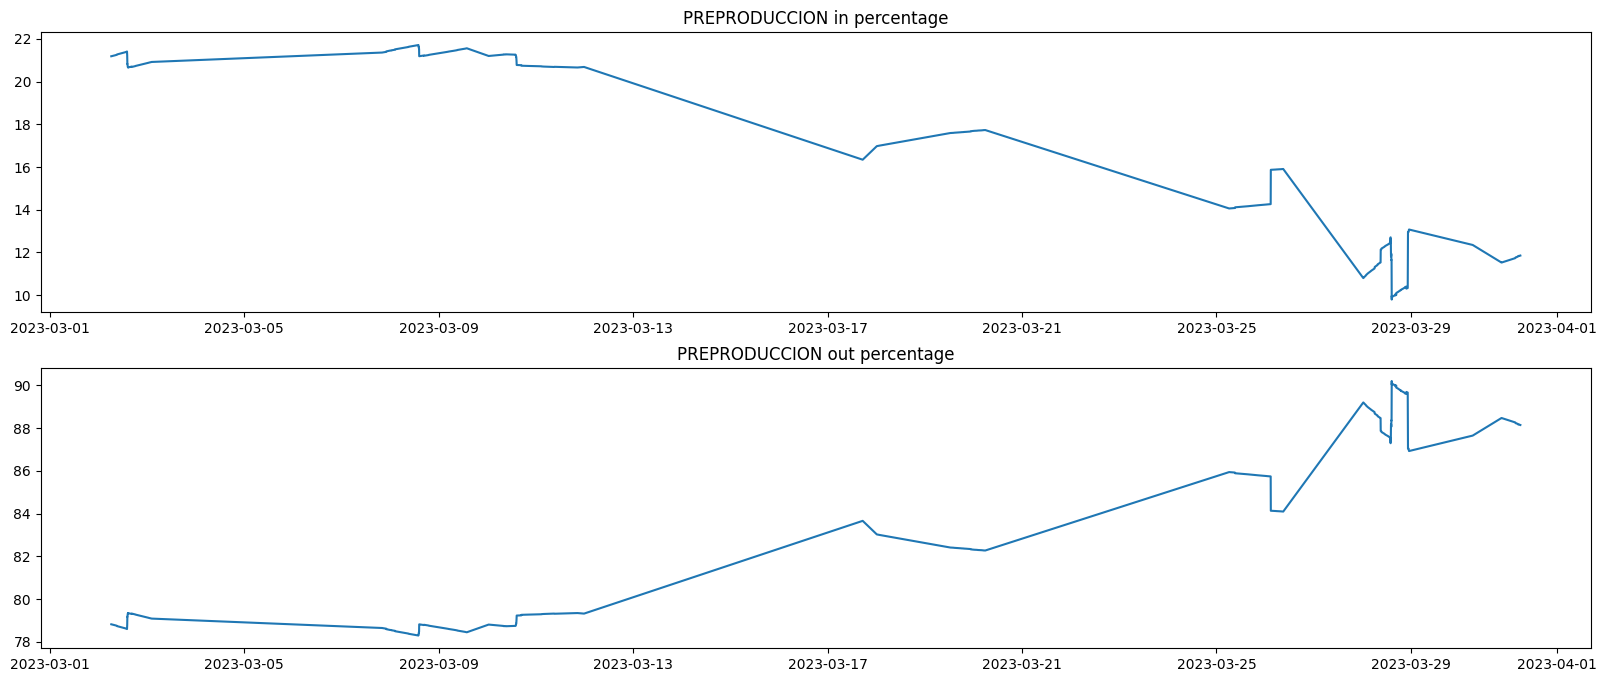

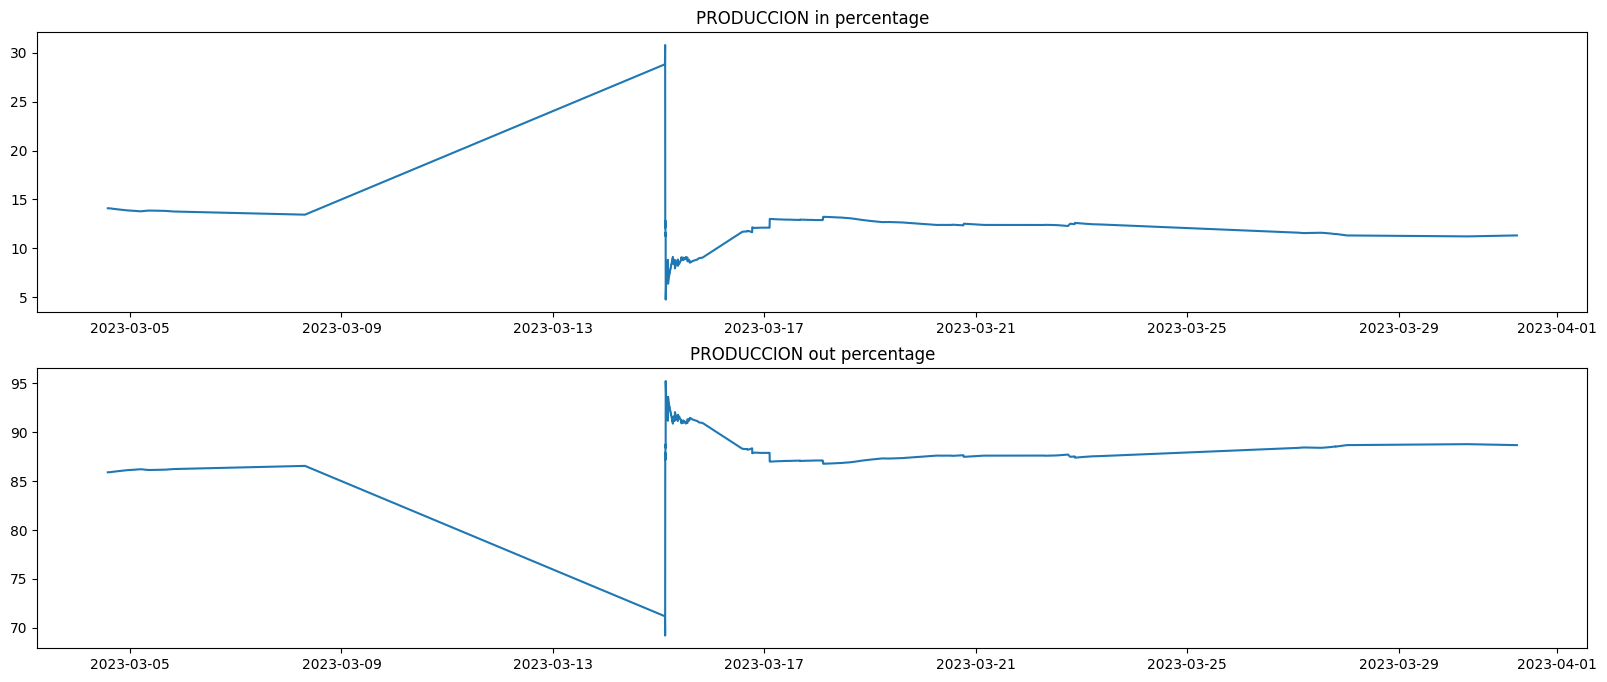

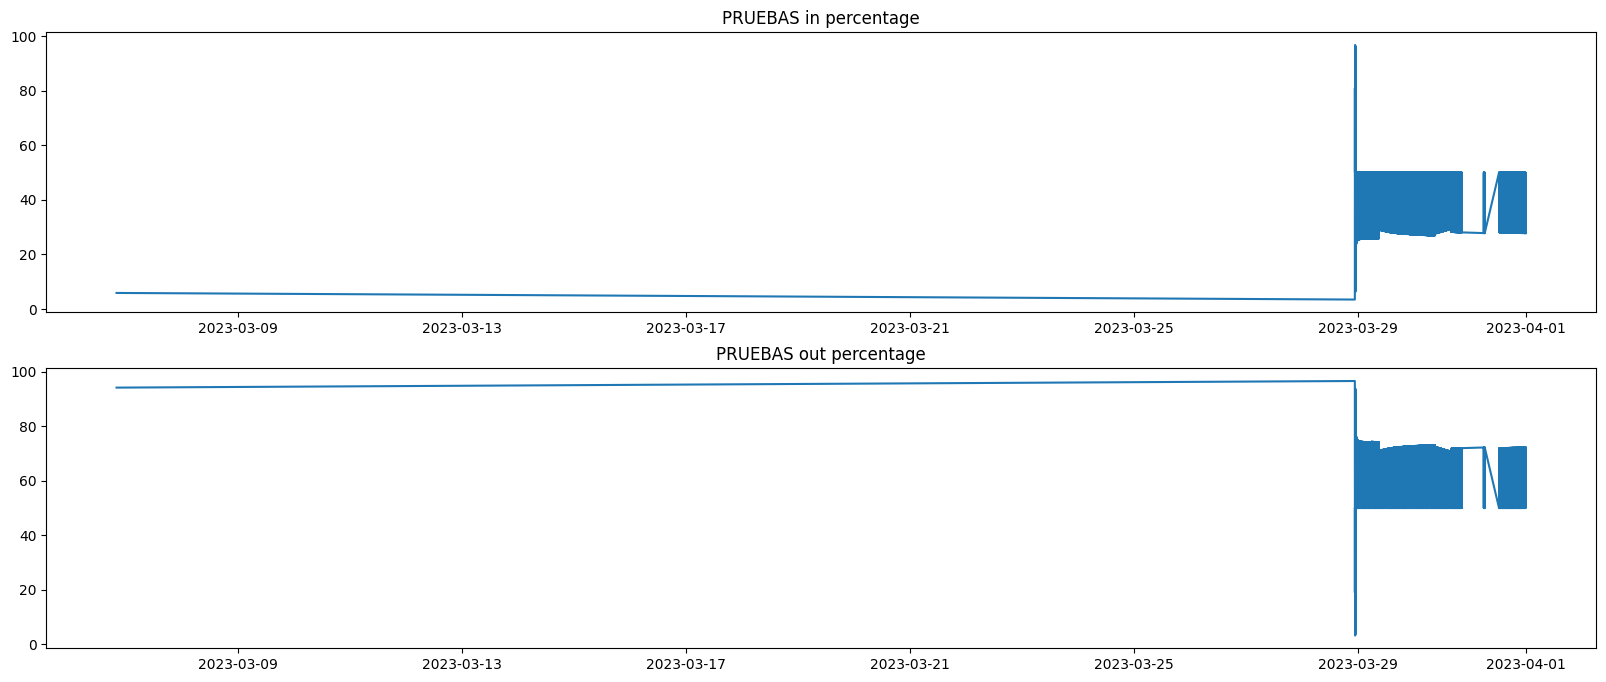

In [47]:
plot_network_info(out2, servers)

We can now see the distribution over time for every datacenter. This will later help us in detecting anomalies for specific data nodes.

In [8]:
network = net2.to_pandas()

Now we want to see the general distributino of all the nodes together.

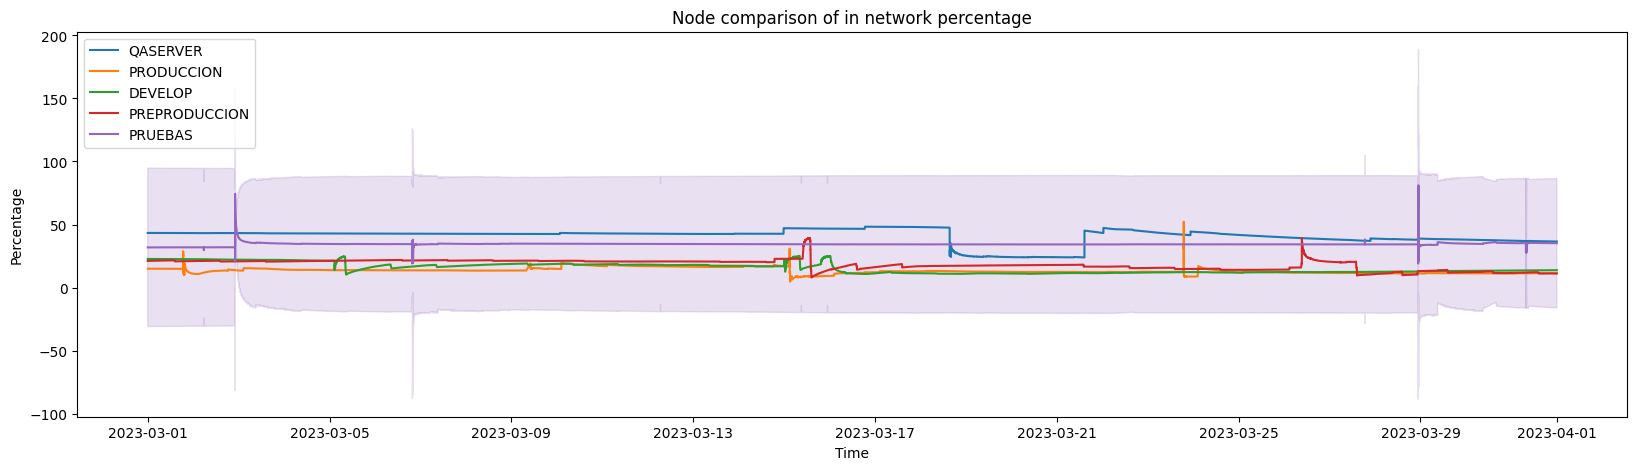

In [66]:
plt.figure(figsize=(20,5))

sns.lineplot(data=network, x="timestamp", y="in.pct", hue = 'node', errorbar=("sd", 4))
plt.title('Node comparison of in network percentage')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.legend(loc='upper left')
plt.show()

### Spectral analysis for anomaly detection

For this approach we will be utilizing a technique microsoft developed based on the following paper

https://arxiv.org/pdf/1906.03821.pdf

First we want to set the variables. For now we will stick with the example variables and try to fine tune them later.

In [9]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

df = out2

Now we want to test the library and see how everything look in the anomaly score.

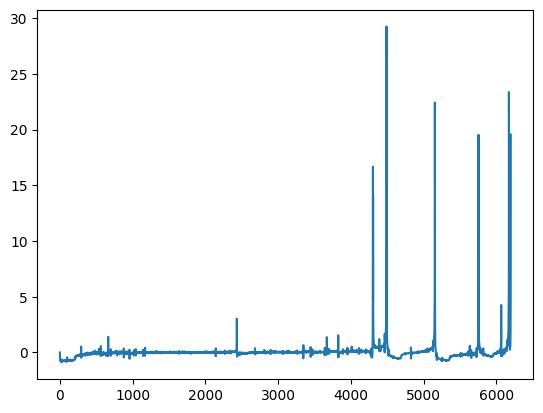

In [214]:
spec = anom.Silency(amp_window_size, series_window_size, score_window_size)

# test_signal = df[(df.index > '2023-03-04 12:00:00') & (df.index < '2023-03-04 18:00:00')]['out.pct']
test_signal = df[df['node'] == 'QASERVER']['in.pct']

score = spec.generate_anomaly_score(test_signal)
plt.plot(score)

We can see there are moments where it definetly increases. For now lets plot these scores on our timeseries to see how the anomalies distribute generally.

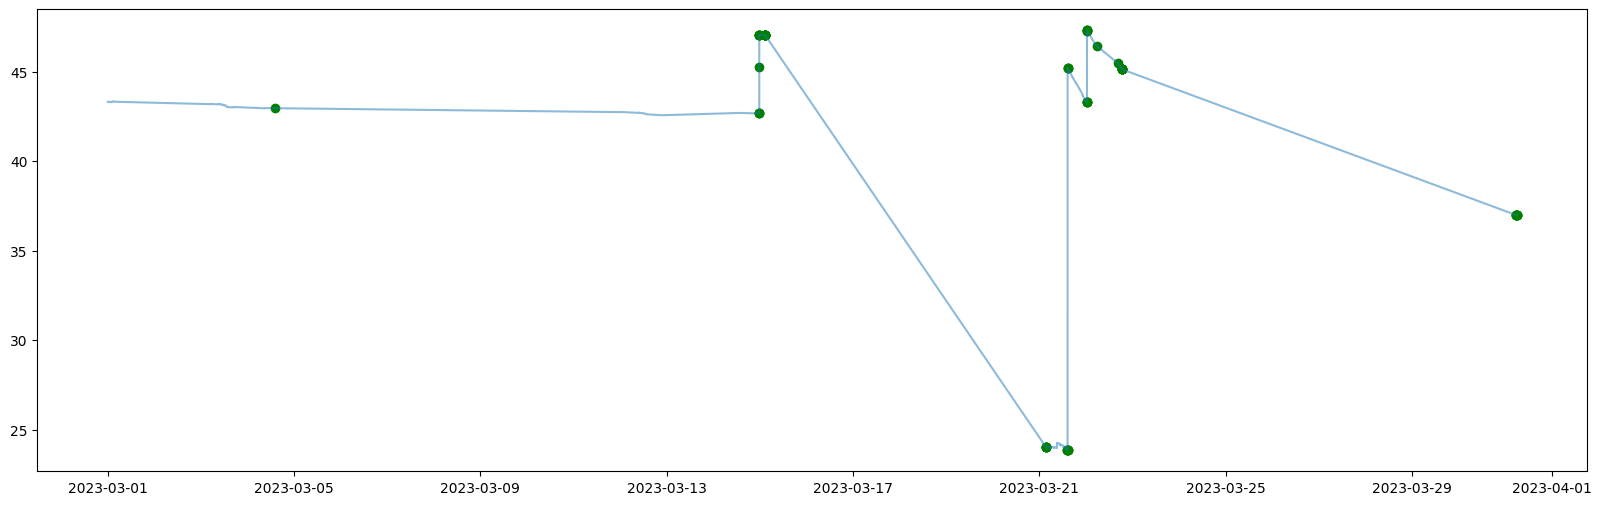

In [215]:
plt.figure(figsize=(20, 6))
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
# plt.scatter(test_signal.iloc[index_changes], test_signal.iloc[index_changes], c='r')
plt.scatter(test_signal.iloc[index_changes].index, y = test_signal.iloc[index_changes], c='green', label="change point")

The results are pretty interesting for the general case. Now we want to try it for a particular case. We will also create a function to make this easier.

In [223]:
def spectral_anomaly_plot(df, amp_window_size=24, series_window_size=24, score_window_size=100, network='in.pct', node = None, timerange = None):
    spec = anom.Silency(amp_window_size, series_window_size, score_window_size)

    if node:
        test_signal = df[df['node'] == node][network]
    else:
        test_signal = df[network]

    if timerange:
        test_signal = test_signal[(test_signal.index > timerange[0]) & (test_signal.index < timerange[1])]
    

    score = spec.generate_anomaly_score(test_signal)
    plt.figure(figsize=(20, 6))
    plt.plot(test_signal, alpha=0.5, label="observation")
    if node == None:
        node = 'all'
    plt.title(f'{node} anomalies for {network}')
    index_changes = np.where(score > np.percentile(score, 99))[0]
    plt.scatter(test_signal.iloc[index_changes].index, y = test_signal.iloc[index_changes], c='green', label="change point")

In [200]:
servers = df.node.unique()

In [201]:
servers

array(['QASERVER', 'DEVELOP', 'PREPRODUCCION', 'PRODUCCION', 'PRUEBAS'],
      dtype=object)

In [237]:
test = df[df['node'] == 'QASERVER']['out.pct']
timerange=['2023-03-02 12:00:00','2023-03-03 12:00:00']
test = test[(test.index > timerange[0]) & (test.index < timerange[1])]
test

timestamp
2023-03-03 02:16:00    56.799748
2023-03-03 02:17:00    56.799791
2023-03-03 02:18:00    56.799749
2023-03-03 02:19:00    56.799939
2023-03-03 02:20:00    56.800746
                         ...    
2023-03-03 11:55:00    56.852852
2023-03-03 11:56:00    56.853419
2023-03-03 11:57:00    56.853585
2023-03-03 11:58:00    56.853636
2023-03-03 11:59:00    56.853840
Name: out.pct, Length: 584, dtype: float64

/opt/homebrew/lib/python3.10/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


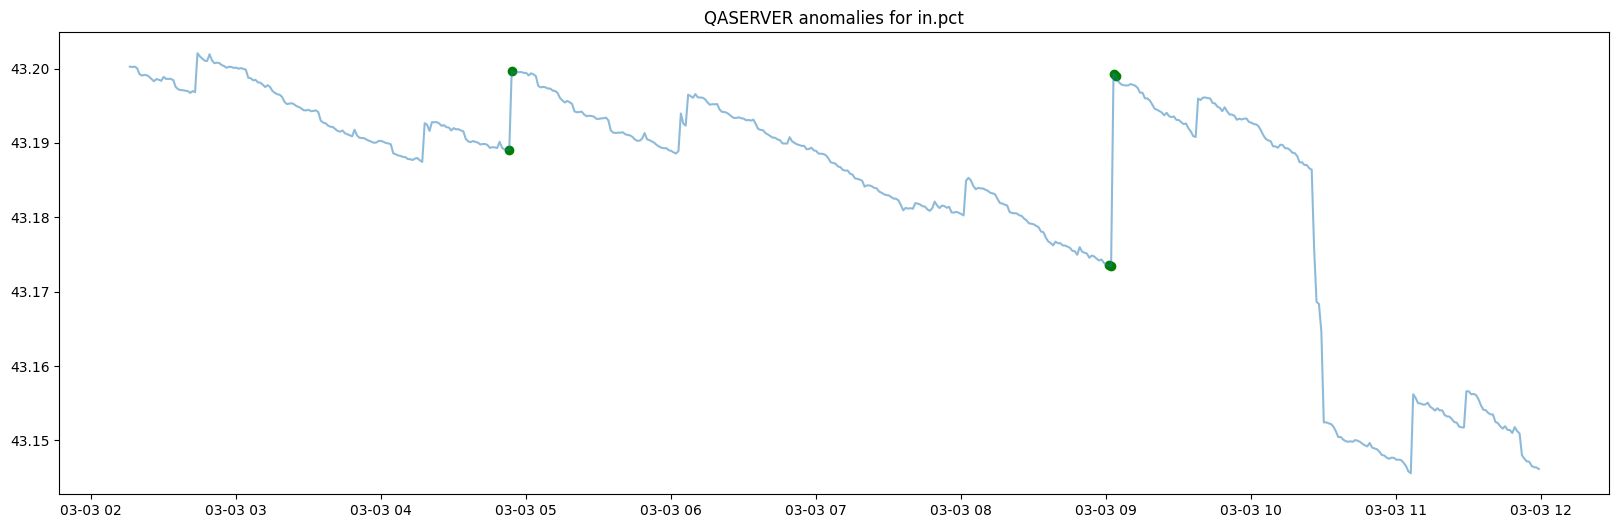

In [238]:
spectral_anomaly_plot(df, node = 'QASERVER', timerange=['2023-03-02 15:00:00','2023-03-03 12:00:00'])

### Network Forcast

In [10]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA

<AxesSubplot: xlabel='timestamp'>

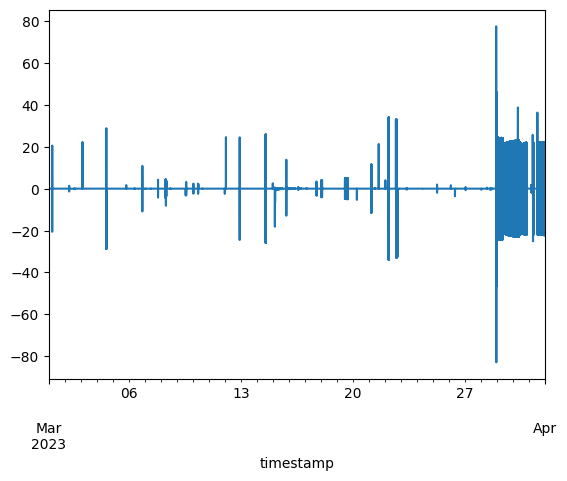

In [11]:
df['in.pct'].diff().plot()

In [12]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [33]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = series.to_frame()
            anomalies[series<lower_bond] = series[series<lower_bond].values.reshape(-1,1)
            anomalies[series>upper_bond] = series[series>upper_bond].values.reshape(-1,1)
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

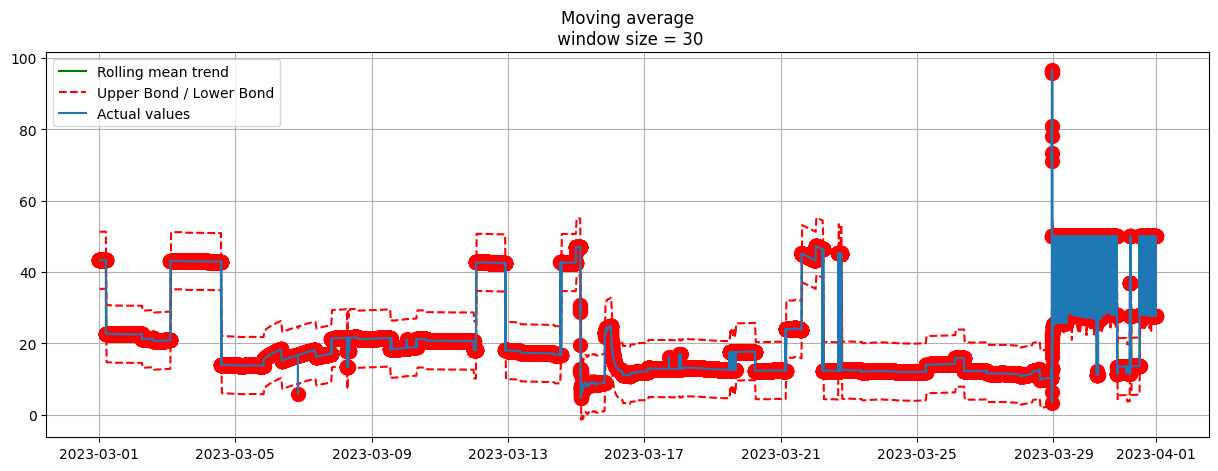

In [34]:
plotMovingAverage(df['in.pct'], 30, plot_intervals=True, plot_anomalies=True) 

In [35]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [39]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from scipy.optimize import minimize 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [43]:
data = df['in.pct'][:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0004619367331177848 0.0 0.005313948233118593


In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [71]:
%%time
slen = 100 # 30-day seasonality
data = df['in.pct'][:-slen] 

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = slen, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0010113071836420628 0.0 0.0010460305614307108
CPU times: user 41.8 s, sys: 633 ms, total: 42.5 s
Wall time: 42.5 s


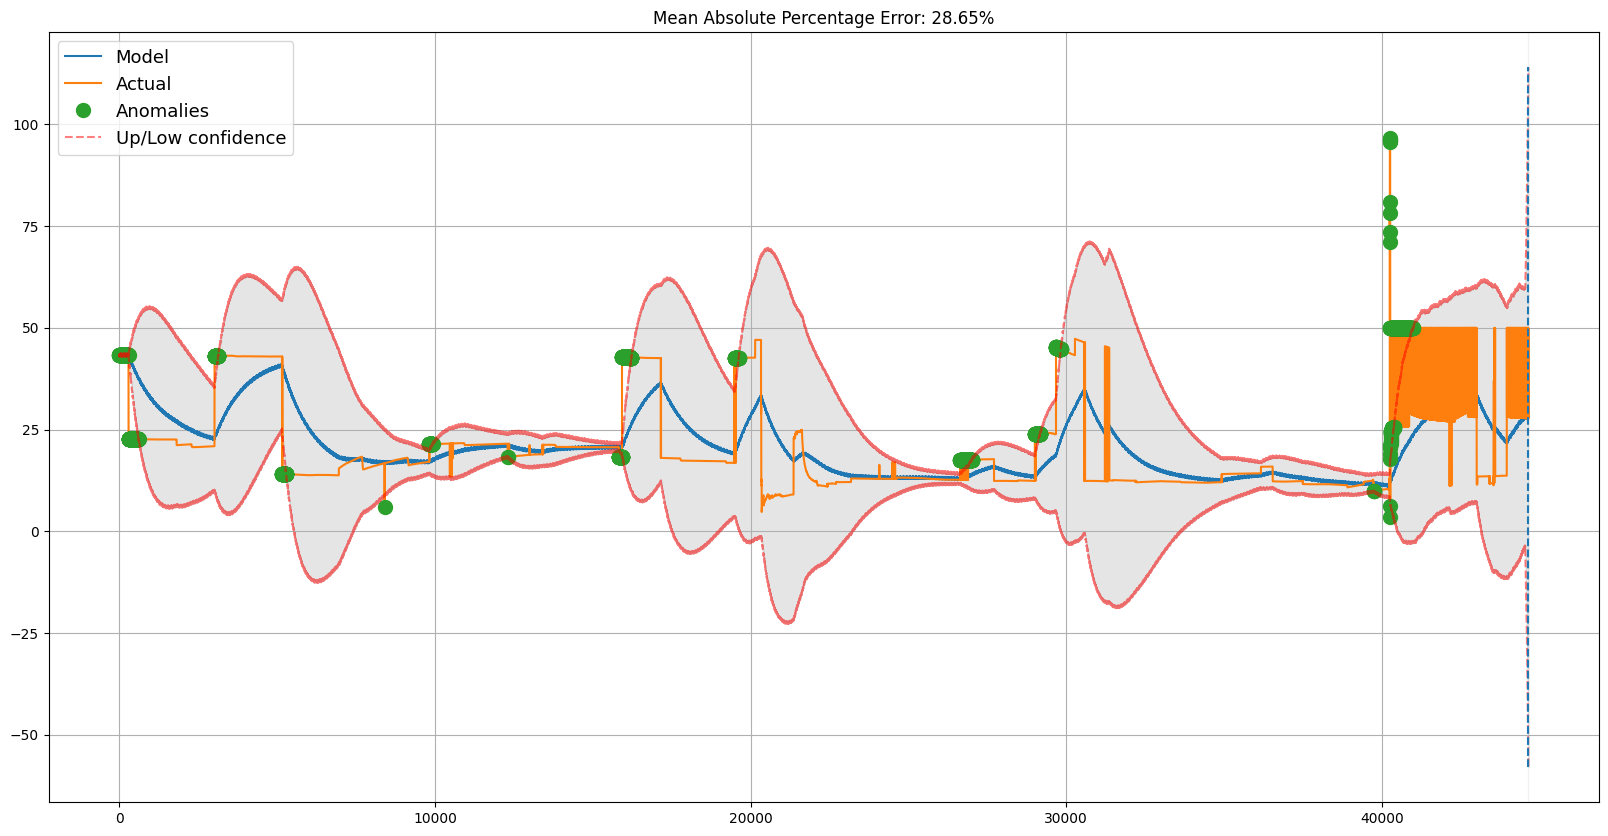

In [72]:
plotHoltWinters(df['in.pct'], plot_intervals=True, plot_anomalies=True)

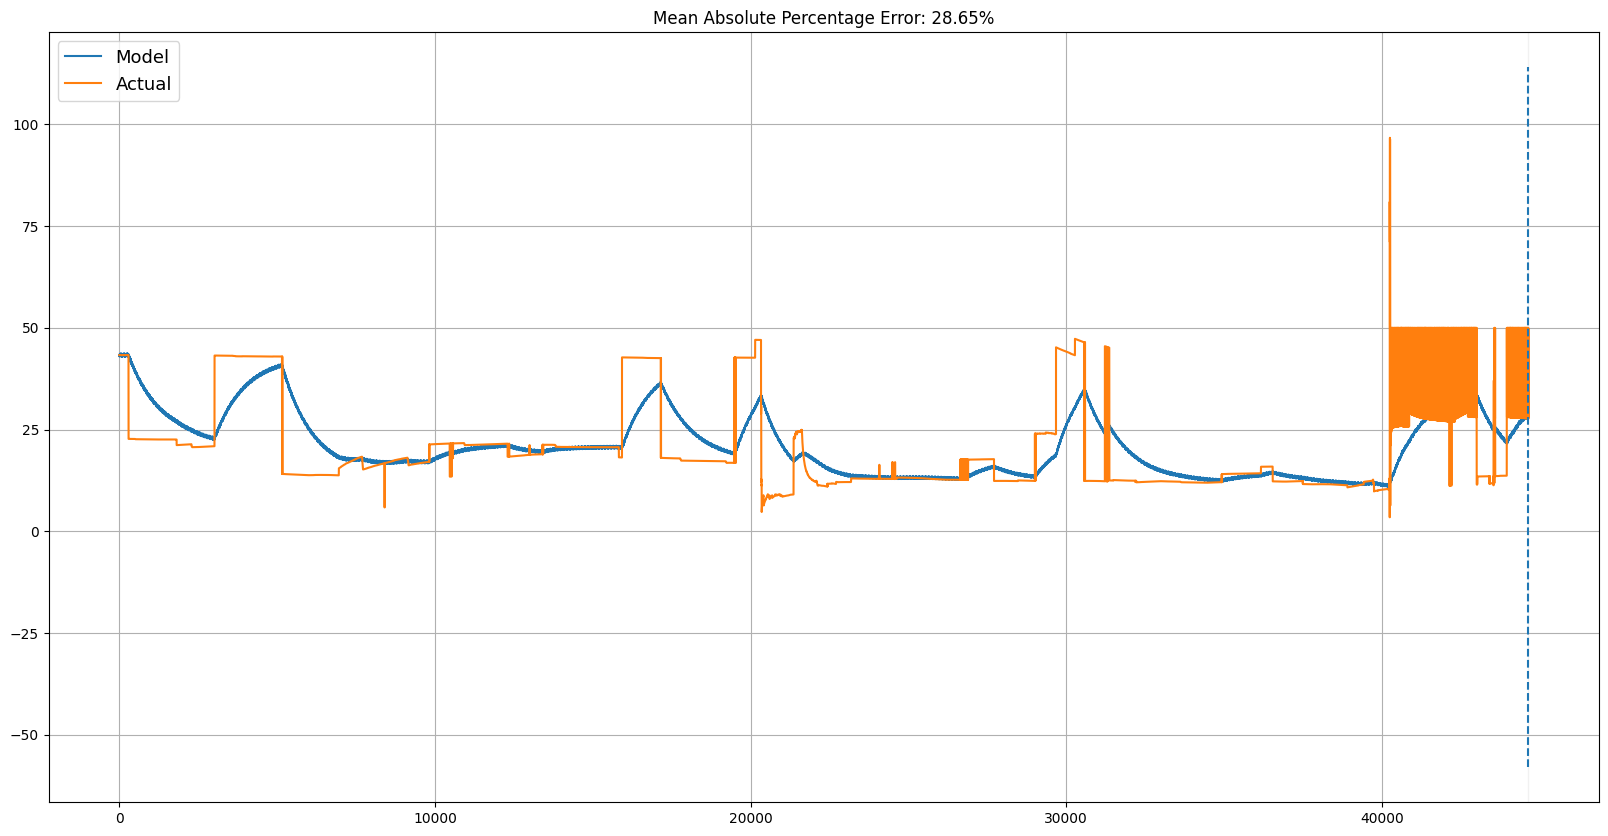

In [73]:
plotHoltWinters(df['in.pct'])


# Extra

In [253]:
df['in.pct.boxcot'], lam = boxcox(df['in.pct'])
df["in.pct.stationary"] = df["in.pct.boxcot"].diff()

# Split train and test
train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

# Train model
model = ARIMA(train[train.isna() == False]['in.pct.stationary'], order=(0, 0, 13)).fit()

In [255]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go
from scipy.stats import boxcox


transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['in.pct.boxcot'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)
print(forecasts)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['in.pct'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['in.pct'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model')

[14.19760493 14.19729561 14.19706041 ... 11.99127983 11.99106817
 11.99085651]


In [ ]:
import streamlit as st

# st.markdown('Streamlit is **_really_ cool**.')
# st.markdown(”This text is :red[colored red], and this is **:blue[colored]** and bold.”)
# st.markdown(":green[$\sqrt{x^2+y^2}=1$] is a Pythagorean identity. :pencil:")
st.markdown('# Network')
st.markdown('## The data')
st.markdown('The data for this particular system is divided into node, which is a commonality among all of the three systems, incoming traffic in bytes or **in**, and outgoing traffic in bytes or **out**')
st.markdown('For the data we did a resampling of 1 minute. We saw that updates came once every 20 seconds, so we decided to compress the data to make it easier to read.')
st.markdown('To standarize data among all nodes we decided to change in and out bytes to a percentage. Meaning we have the percent of in bytes agains all bytes at that time and the same for out bytes')
st.markdown('### EDA')
st.markdown('To understand the data we first wrote a function called `plot_network_info`, which shows us the data of each of the nodes in a time series. This was usefull for we were')
st.markdown('Able to see periodicity and see some clear examples of outliers. After that function came a lineplot comparison where we utilize seabron to visualize the change in time')
st.markdown('of all the nodes against each other and can start to get a sense of wheter it\'s related or not.' )
st.markdown('## Anomaly detection')
st.markdown('For anomaly detection we decided to apply a concept that microsoft utilizes with their own servers for anomaly detection. First we imported a libreary since the functions')
st.markdown('Where already written for us to use. The code base for the function isn\'t to long, but it\'s still better to import than to copy.')
st.markdown('The function we utilize is based on spectral anomaly detection via use of CNNs. The main role is to change our data utilizing a fourier transform, allowing the CNN to understand')
st.markdown('what is happening to our 1 dimensional data. Afterwards we get an output for wheter the CNN believes the input is a anomaly based on the probability that it is. We chose to')
st.markdown('set that any value above 99 percent certainty is considered an outlier. The paper from which we got the idea is https://arxiv.org/pdf/1906.03821.pdf. This probability is then')
st.markdown('returned to us as a score, where the higher the number the more likely it is an anomaly.')
st.markdown('After seeing that the algorithm worked we then created a function to not only calculate our score for the data point, but also to plot the results and see wheter it looks')
st.markdown('correct.')